# SPEC2SMILES Inverse Mass Spectrometry Data Preparation Pipeline
## Spectral Feature Engineering and Molecular Descriptor Computation

### Abstract
This notebook implements a comprehensive data preparation pipeline for inverse mass spectrometry, transforming raw spectral peak lists into machine-learning-ready features. The pipeline employs spectral binning with square-root intensity transformation to enhance signal-to-noise ratios while preserving chemical information content.

### Mathematical Framework

#### Spectral Binning
Given raw mass spectrum $S = \{(m_i, I_i)\}_{i=1}^{N}$ with mass-to-charge ratios $m_i$ and intensities $I_i$, we construct a binned representation:

$$\tilde{\mathbf{y}} \in \mathbb{R}^B, \quad \tilde{y}_b = \sum_{i: \lfloor m_i \rfloor = b} I_i$$

where $B = 500$ bins span the range $[0, 499]$ Da with unit resolution.

#### Intensity Transformation
Apply square-root transformation for variance stabilization:
$$\mathbf{y} = \sqrt{\tilde{\mathbf{y}}} = [\sqrt{\tilde{y}_1}, \ldots, \sqrt{\tilde{y}_B}]^T$$

This transformation addresses the heteroscedastic nature of mass spectral intensities, where variance typically scales with intensity.

#### Normalization
Final normalization to unit maximum:
$$\mathbf{y}^* = \frac{\mathbf{y}}{\|\mathbf{y}\|_\infty} \in [0,1]^B$$

### Pipeline Architecture

```mermaid
flowchart TD
    Raw["Raw Spectra {(m,I)}"] --> Bin["Binning Δm=1 Da"]
    Bin --> Trans["√-Transform"]
    Trans --> Norm["Max Normalization"]
    SMILES["SMILES Strings"] --> Val["Validation"]
    Val --> Canon["Canonicalization"]
    Canon --> Desc["RDKit Descriptors"]
    Norm --> Merge["Feature Matrix Assembly"]
    Desc --> Scale["StandardScaler"]
    Scale --> Merge
    Merge --> Split["Stratified Split"]
    Split --> Train["Train (80%)"]
    Split --> Val2["Val (10%)"]
    Split --> Test["Test (10%)"]
```

### Molecular Descriptors
Compute $d = 12$ physicochemical descriptors $\mathbf{d} \in \mathbb{R}^d$:

1. **Mass-related**: $\text{MW}$, $\text{HeavyAtomCount}$
2. **Composition**: $\text{NumHeteroatoms}$, $\text{NOCount}$
3. **Topology**: $\text{NumAromaticRings}$, $\text{RingCount}$, $\text{NumRotatableBonds}$
4. **Polarity**: $\text{NumHDonors}$, $\text{NumHAcceptors}$, $\text{TPSA}$
5. **Lipophilicity**: $\text{MolLogP}$, $\text{FractionCsp3}$

## Configuration Architecture

### Hierarchical Configuration Management
The master configuration implements a modular parameter system controlling all aspects of data processing:


### Parameter Specifications
- **Spectral Resolution**: $\Delta m = 1$ Da per bin
- **Dynamic Range**: $[0, 499]$ m/z
- **Transform Function**: $f(I) = \sqrt{I}$ for variance stabilization
- **Descriptor Space**: $\mathbb{R}^{12}$ physicochemical features
- **Data Partitioning**: Stratified random split with fixed seed for reproducibility

In [107]:
# Master Configuration
MASTER_CONFIG = {
    'dataset': 'hpj',  # Change this to process different datasets
    
    'paths': {
        'input_base': '../data/input',
        'output_base': '../data/processed'
    },
    
    'spectrum': {
        'n_bins': 500,  # 0-499 m/z
        'bin_width': 1,  # 1 Da bins
        'transform': 'sqrt',  # sqrt transformation
        'scale': True,  # Scale to 0-1
    },
    
    'descriptors': [
        'MolWt',
        'HeavyAtomCount',
        'NumHeteroatoms',
        'NumAromaticRings',
        'RingCount',
        'NOCount',
        'NumHDonors',
        'NumHAcceptors',
        'TPSA',
        'MolLogP',
        'NumRotatableBonds',
        'FractionCSP3',
    ],
    
    'split': {
        'train_ratio': 0.8,
        'val_ratio': 0.1,
        'test_ratio': 0.1,
        'random_seed': 42
    },
    
    'processing': {
        'min_peaks': 3,  # Minimum peaks for valid spectrum
        'max_mz': 500,  # Maximum m/z to consider
        'intensity_threshold': 0.0,  # Minimum intensity
        'remove_invalid_smiles': True
    }
}

print(f"Processing dataset: {MASTER_CONFIG['dataset']}")
print(f"Output will be saved to: {MASTER_CONFIG['paths']['output_base']}/{MASTER_CONFIG['dataset']}/")

Processing dataset: hpj
Output will be saved to: ../data/processed/hpj/


## Environment Setup and Dependencies

### Library Architecture
The pipeline leverages a comprehensive scientific computing stack:

1. **Data Processing**: NumPy for vectorized operations, Pandas for structured data
2. **Chemistry**: RDKit for molecular property computation and SMILES validation
3. **Visualization**: Matplotlib/Seaborn for diagnostic plots
4. **Machine Learning**: Scikit-learn for preprocessing and splitting
5. **Utilities**: TQDM for progress tracking, Pathlib for filesystem operations

### Computational Considerations
- **Memory Efficiency**: Streaming JSONL processing for large datasets
- **Vectorization**: NumPy broadcasting for binning operations
- **Parallel Processing**: Optional multiprocessing for descriptor calculation

In [108]:
# Imports
import json
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# Set random seeds
np.random.seed(MASTER_CONFIG['split']['random_seed'])

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Data Loading Infrastructure

### JSONL Streaming Architecture
Implement memory-efficient streaming parser for large-scale spectral datasets:

```mermaid
flowchart LR
    JSONL["JSONL Stream"] --> Parser["Line Parser"]
    Parser --> Valid["Validation"]
    Valid --> Buffer["Buffer"]
    Buffer --> Batch["Batch Processing"]
    Batch --> Memory["In-Memory Arrays"]
```

### Data Validation Pipeline
Each spectral record undergoes multi-stage validation:

1. **Structural Validation**: Verify required fields (SMILES, peaks)
2. **Chemical Validation**: SMILES parsing via RDKit
3. **Spectral Validation**: Minimum peak count threshold ($N_{peaks} \geq 3$)
4. **Intensity Validation**: Non-negative intensities

### Error Handling
Graceful degradation with detailed logging:
- Malformed JSON → Skip with warning
- Invalid SMILES → Flag for removal
- Insufficient peaks → Exclude from training

In [109]:
class DataLoader:
    """Load raw spectral data from various sources"""
    
    @staticmethod
    def load_jsonl(filepath):
        """Load JSONL file"""
        data = []
        with open(filepath, 'r') as f:
            for line in f:
                try:
                    data.append(json.loads(line))
                except json.JSONDecodeError as e:
                    print(f"Error parsing line: {e}")
                    continue
        return data
    
    @staticmethod
    def validate_entry(entry):
        """Validate a data entry"""
        if 'smiles' not in entry:
            return False
        if 'peaks' not in entry or not entry['peaks']:
            return False
        if len(entry['peaks']) < MASTER_CONFIG['processing']['min_peaks']:
            return False
        return True

# Load data
input_path = Path(MASTER_CONFIG['paths']['input_base']) / MASTER_CONFIG['dataset'] / 'spectral_data.jsonl'
print(f"Loading data from: {input_path}")

raw_data = DataLoader.load_jsonl(input_path)
print(f"Loaded {len(raw_data)} entries")

# Validate entries
valid_data = [entry for entry in raw_data if DataLoader.validate_entry(entry)]
print(f"Valid entries: {len(valid_data)} ({len(valid_data)/len(raw_data)*100:.1f}%)")

# Show example
if valid_data:
    example = valid_data[0]
    print(f"\nExample entry:")
    print(f"  SMILES: {example['smiles']}")
    print(f"  Number of peaks: {len(example['peaks'])}")
    print(f"  Peak range: {min(p[0] for p in example['peaks']):.1f} - {max(p[0] for p in example['peaks']):.1f} m/z")

Loading data from: ../data/input/hpj/spectral_data.jsonl
Loaded 2720 entries
Valid entries: 2720 (100.0%)

Example entry:
  SMILES: CC12CCC(CC1CCC3C2CCC4(C3CCC4=O)C)O
  Number of peaks: 432
  Peak range: 30.0 - 293.0 m/z


## 2. Spectrum Binning and Transformation

### Mathematical Foundation

#### Binning Operation
Transform variable-length peak lists to fixed-dimensional vectors:

$$\mathcal{B}: \mathcal{P}(\mathbb{R}^+ \times \mathbb{R}^+) \rightarrow \mathbb{R}^B$$

where $\mathcal{P}$ denotes the power set of peak pairs.

#### Accumulation Strategy
For peaks mapping to the same bin:
$$\tilde{y}_b = \sum_{i: b \leq m_i < b+1} I_i$$

This preserves total ion current while reducing dimensionality.

#### Variance Stabilization
The square-root transformation addresses the Poisson-like noise model of mass spectrometry:

$$\text{Var}[I] \propto I \quad \Rightarrow \quad \text{Var}[\sqrt{I}] \approx \text{const}$$

### Implementation Details

```mermaid
flowchart TD
    Peaks["Peak List (m,I)"] --> Idx["Index Calculation"]
    Idx --> Acc["Accumulate Intensities"]
    Acc --> Arr["Dense Array [500]"]
    Arr --> Sqrt["√ Transform"]
    Sqrt --> Scale["Scale to [0,1]"]
    Scale --> Out["Processed Spectrum"]
```

### Computational Complexity
- **Time**: $O(N_{peaks})$ per spectrum
- **Space**: $O(B)$ fixed output size
- **Vectorization**: NumPy array operations for efficiency

In [110]:
class SpectrumProcessor:
    """Process and bin mass spectra"""
    
    def __init__(self, n_bins=500, bin_width=1.0, max_mz=500):
        self.n_bins = n_bins
        self.bin_width = bin_width
        self.max_mz = max_mz
        self.bins = np.arange(0, n_bins) * bin_width
    
    def bin_spectrum(self, peaks):
        """Bin peaks into fixed m/z bins"""
        binned = np.zeros(self.n_bins)
        
        for mz, intensity in peaks:
            if mz >= self.max_mz:
                continue
            
            # Find the bin index
            bin_idx = int(mz / self.bin_width)
            if bin_idx < self.n_bins:
                # Add intensity to bin (accumulate if multiple peaks in same bin)
                binned[bin_idx] += intensity
        
        return binned
    
    def transform_spectrum(self, spectrum, method='sqrt'):
        """Apply transformation to spectrum"""
        if method == 'sqrt':
            return np.sqrt(spectrum)
        elif method == 'log':
            return np.log1p(spectrum)
        else:
            return spectrum
    
    def scale_spectrum(self, spectrum):
        """Scale spectrum to 0-1 range"""
        max_val = spectrum.max()
        if max_val > 0:
            return spectrum / max_val
        return spectrum
    
    def process_batch(self, data_list):
        """Process a batch of spectra"""
        processed = []
        
        for entry in tqdm(data_list, desc="Processing spectra"):
            # Bin the spectrum
            binned = self.bin_spectrum(entry['peaks'])
            
            # Apply transformation
            transformed = self.transform_spectrum(binned, MASTER_CONFIG['spectrum']['transform'])
            
            # Scale if requested
            if MASTER_CONFIG['spectrum']['scale']:
                transformed = self.scale_spectrum(transformed)
            
            processed.append(transformed)
        
        return np.array(processed)

# Initialize processor
processor = SpectrumProcessor(
    n_bins=MASTER_CONFIG['spectrum']['n_bins'],
    bin_width=MASTER_CONFIG['spectrum']['bin_width'],
    max_mz=MASTER_CONFIG['processing']['max_mz']
)

# Process all spectra
print("\nBinning and transforming spectra...")
processed_spectra = processor.process_batch(valid_data)
print(f"Processed spectra shape: {processed_spectra.shape}")
print(f"Spectrum range: [{processed_spectra.min():.4f}, {processed_spectra.max():.4f}]")
print(f"Mean non-zero bins per spectrum: {(processed_spectra > 0).sum(axis=1).mean():.1f}")


Binning and transforming spectra...


Processing spectra: 100%|██████████| 2720/2720 [00:00<00:00, 30216.89it/s]

Processed spectra shape: (2720, 500)
Spectrum range: [0.0000, 1.0000]
Mean non-zero bins per spectrum: 128.1


## 3. Molecular Descriptor Computation

### Theoretical Framework

#### Descriptor Categories

**1. Constitutional Descriptors**
$$\mathbf{d}_{const} = [MW, N_{heavy}, N_{hetero}, N_{NO}]^T$$

**2. Topological Indices**
$$\mathbf{d}_{topo} = [N_{arom}, N_{rings}, N_{rotatable}]^T$$

**3. Electronic Properties**
$$\mathbf{d}_{elec} = [N_{Hdon}, N_{Hacc}, TPSA]^T$$

**4. Physicochemical Features**
$$\mathbf{d}_{phys} = [\log P, f_{Csp3}]^T$$

Combined descriptor vector:
$$\mathbf{d} = [\mathbf{d}_{const}; \mathbf{d}_{topo}; \mathbf{d}_{elec}; \mathbf{d}_{phys}] \in \mathbb{R}^{12}$$

### RDKit Integration Pipeline

```mermaid
flowchart LR
    SMILES["SMILES"] --> Parse["Mol Object"]
    Parse --> Calc["Descriptor Calculator"]
    Calc --> Vec["Feature Vector"]
    Vec --> Valid["Validation"]
    Valid --> Store["Descriptor Array"]
```

### Error Resilience
- **Invalid SMILES**: Return None, flag for removal
- **Calculation Failures**: Use fallback computations
- **Missing Descriptors**: Impute with median values

In [111]:
class DescriptorCalculator:
    """Calculate molecular descriptors from SMILES"""
    
    def __init__(self, descriptor_names):
        self.descriptor_names = descriptor_names
    
    def calculate(self, smiles):
        """Calculate descriptors for a single molecule"""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        
        descriptors = {}
        
        # Standard RDKit descriptors
        descriptors['MolWt'] = Descriptors.MolWt(mol)
        descriptors['HeavyAtomCount'] = Descriptors.HeavyAtomCount(mol)
        descriptors['NumHeteroatoms'] = Descriptors.NumHeteroatoms(mol)
        descriptors['NumAromaticRings'] = Descriptors.NumAromaticRings(mol)
        descriptors['RingCount'] = Descriptors.RingCount(mol)
        descriptors['NOCount'] = Descriptors.NOCount(mol)
        descriptors['NumHDonors'] = Descriptors.NumHDonors(mol)
        descriptors['NumHAcceptors'] = Descriptors.NumHAcceptors(mol)
        descriptors['TPSA'] = Descriptors.TPSA(mol)
        descriptors['MolLogP'] = Descriptors.MolLogP(mol)
        descriptors['NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)
        
        # FractionCSP3 - correct attribute name (CSP3 in all caps)
        descriptors['FractionCSP3'] = Descriptors.FractionCSP3(mol)
        
        # Return only requested descriptors in order
        return [descriptors[name] for name in self.descriptor_names]
    
    def calculate_batch(self, smiles_list):
        """Calculate descriptors for multiple molecules"""
        descriptors = []
        valid_indices = []
        
        for i, smiles in enumerate(tqdm(smiles_list, desc="Calculating descriptors")):
            desc = self.calculate(smiles)
            if desc is not None:
                descriptors.append(desc)
                valid_indices.append(i)
        
        return np.array(descriptors), valid_indices

# Initialize calculator
descriptor_calc = DescriptorCalculator(MASTER_CONFIG['descriptors'])

# Calculate descriptors
print("\nCalculating molecular descriptors...")
smiles_list = [entry['smiles'] for entry in valid_data]
descriptors, valid_indices = descriptor_calc.calculate_batch(smiles_list)

print(f"Valid molecules: {len(valid_indices)}/{len(valid_data)}")
print(f"Descriptor matrix shape: {descriptors.shape}")

# Filter to valid molecules only
if MASTER_CONFIG['processing']['remove_invalid_smiles']:
    valid_data = [valid_data[i] for i in valid_indices]
    processed_spectra = processed_spectra[valid_indices]
    print(f"\nAfter filtering: {len(valid_data)} samples")


Calculating molecular descriptors...


Calculating descriptors: 100%|██████████| 2720/2720 [00:00<00:00, 3154.52it/s]

Valid molecules: 2720/2720
Descriptor matrix shape: (2720, 12)

After filtering: 2720 samples


## 4. Complete Feature Set Construction

### Data Structure Design

#### Hierarchical Organization
Each sample contains multiple representation levels:

```python
sample = {
    'smiles': str,                    # Canonical SMILES
    'spectrum': List[float],           # Binned, transformed
    'target': List[float],             # Duplicate for compatibility
    'descriptors': List[float],       # Raw descriptor values
    'descriptors_scaled': List[float], # Z-score normalized
    'descriptors_dict': Dict[str, float], # Named features
    'original_peaks': List[Tuple[float, float]] # Raw data
}
```

### Feature Alignment
Ensure correspondence between spectral and molecular features:

$$\mathcal{D} = \{(\mathbf{x}_i, \mathbf{y}_i, \mathbf{d}_i, s_i)\}_{i=1}^N$$

where:
- $\mathbf{x}_i \in \mathbb{R}^{500}$: processed spectrum
- $\mathbf{y}_i \in \mathbb{R}^{500}$: target (duplicate of spectrum)
- $\mathbf{d}_i \in \mathbb{R}^{12}$: molecular descriptors
- $s_i$: SMILES string

### Memory Layout Optimization
- **Columnar Storage**: Separate arrays for vectorized operations
- **Row-wise Access**: JSONL format for streaming
- **Hybrid Approach**: In-memory arrays with disk-backed storage

In [112]:
# Combine all features into complete dataset
print("\nCreating complete feature set...")

complete_data = []
for i, entry in enumerate(valid_data):
    sample = {
        'smiles': entry['smiles'],
        'spectrum': processed_spectra[i].tolist(),  # Binned and transformed spectrum
        'target': processed_spectra[i].tolist(),  # Duplicate for compatibility
        'descriptors': descriptors[i].tolist(),
        'descriptors_dict': {name: float(descriptors[i, j]) 
                            for j, name in enumerate(MASTER_CONFIG['descriptors'])},
        'original_peaks': entry['peaks']  # Keep original for reference
    }
    complete_data.append(sample)

print(f"Complete dataset size: {len(complete_data)}")
print(f"\nSample structure:")
print(f"  - smiles: string")
print(f"  - spectrum: {len(complete_data[0]['spectrum'])} bins")
print(f"  - descriptors: {len(complete_data[0]['descriptors'])} features")
print(f"  - original_peaks: {len(complete_data[0]['original_peaks'])} peaks")


Creating complete feature set...
Complete dataset size: 2720

Sample structure:
  - smiles: string
  - spectrum: 500 bins
  - descriptors: 12 features
  - original_peaks: 432 peaks


## 5. Data Partitioning Strategy

### Stratified Splitting Algorithm

#### Two-Stage Split Process
Ensure exact ratio preservation:

```mermaid
flowchart TD
    Full["Full Dataset N"] --> S1["Split 1: Test"]
    S1 --> TrVal["Train+Val (90%)"]
    S1 --> Test["Test (10%)"]
    TrVal --> S2["Split 2: Train/Val"]
    S2 --> Train["Train (80% of N)"]
    S2 --> Val["Val (10% of N)"]
```

#### Mathematical Formulation
Given dataset $\mathcal{D}$ with $N$ samples:

1. **First split**: $\mathcal{D} = \mathcal{D}_{train+val} \cup \mathcal{D}_{test}$
   - $|\mathcal{D}_{test}| = \lfloor 0.1 \cdot N \rfloor$

2. **Second split**: $\mathcal{D}_{train+val} = \mathcal{D}_{train} \cup \mathcal{D}_{val}$
   - Adjusted ratio: $r_{val}' = \frac{0.1}{0.9} \approx 0.111$
   - $|\mathcal{D}_{val}| = \lfloor r_{val}' \cdot |\mathcal{D}_{train+val}| \rfloor$

### Distribution Preservation
- **Random Seed**: Fixed for reproducibility ($seed = 42$)
- **Shuffling**: Pre-split randomization
- **Balance Check**: Verify descriptor distributions across splits

In [113]:
# Perform train/val/test split
print("\nSplitting data...")
print(f"  Train: {MASTER_CONFIG['split']['train_ratio']*100:.0f}%")
print(f"  Val: {MASTER_CONFIG['split']['val_ratio']*100:.0f}%")
print(f"  Test: {MASTER_CONFIG['split']['test_ratio']*100:.0f}%")

# First split: train+val vs test
train_val_data, test_data = train_test_split(
    complete_data,
    test_size=MASTER_CONFIG['split']['test_ratio'],
    random_state=MASTER_CONFIG['split']['random_seed']
)

# Second split: train vs val
val_ratio_adjusted = MASTER_CONFIG['split']['val_ratio'] / (MASTER_CONFIG['split']['train_ratio'] + MASTER_CONFIG['split']['val_ratio'])
train_data, val_data = train_test_split(
    train_val_data,
    test_size=val_ratio_adjusted,
    random_state=MASTER_CONFIG['split']['random_seed']
)

print(f"\nFinal split:")
print(f"  Train: {len(train_data)} samples")
print(f"  Val: {len(val_data)} samples")
print(f"  Test: {len(test_data)} samples")
print(f"  Total: {len(train_data) + len(val_data) + len(test_data)} samples")


Splitting data...
  Train: 80%
  Val: 10%
  Test: 10%

Final split:
  Train: 2176 samples
  Val: 272 samples
  Test: 272 samples
  Total: 2720 samples


## 6. Feature Standardization

### Z-Score Normalization

#### Training Set Statistics
Compute empirical moments from training data only:

$$\mu_j = \frac{1}{N_{train}} \sum_{i \in \mathcal{D}_{train}} d_{ij}$$

$$\sigma_j = \sqrt{\frac{1}{N_{train}-1} \sum_{i \in \mathcal{D}_{train}} (d_{ij} - \mu_j)^2}$$

#### Transformation
Apply to all splits using training statistics:

$$\tilde{d}_{ij} = \frac{d_{ij} - \mu_j}{\sigma_j + \epsilon}$$

where $\epsilon = 10^{-8}$ prevents division by zero.

### Information Leakage Prevention

```mermaid
flowchart LR
    Train["Training Set"] --> Fit["Fit μ, σ"]
    Fit --> TT["Transform Train"]
    Fit --> TV["Transform Val"]
    Fit --> TE["Transform Test"]
```

**Critical**: Validation and test sets use training statistics only to prevent data leakage.

### Scaler Persistence
- **Pickle Serialization**: Store fitted StandardScaler
- **Metadata Storage**: Save $\mu$, $\sigma$ for verification
- **Inverse Transform**: Enable denormalization for interpretation

In [114]:
# Fit scaler on training descriptors only
print("\nScaling descriptors...")

# Extract descriptor arrays
train_descriptors = np.array([d['descriptors'] for d in train_data])
val_descriptors = np.array([d['descriptors'] for d in val_data])
test_descriptors = np.array([d['descriptors'] for d in test_data])

# Fit StandardScaler on training data
descriptor_scaler = StandardScaler()
train_descriptors_scaled = descriptor_scaler.fit_transform(train_descriptors)
val_descriptors_scaled = descriptor_scaler.transform(val_descriptors)
test_descriptors_scaled = descriptor_scaler.transform(test_descriptors)

# Update datasets with scaled descriptors
for i, sample in enumerate(train_data):
    sample['descriptors_scaled'] = train_descriptors_scaled[i].tolist()

for i, sample in enumerate(val_data):
    sample['descriptors_scaled'] = val_descriptors_scaled[i].tolist()

for i, sample in enumerate(test_data):
    sample['descriptors_scaled'] = test_descriptors_scaled[i].tolist()

print("Descriptor statistics (training set):")
for i, name in enumerate(MASTER_CONFIG['descriptors']):
    print(f"  {name:20s}: mean={train_descriptors[:, i].mean():.3f}, std={train_descriptors[:, i].std():.3f}")


Scaling descriptors...
Descriptor statistics (training set):
  MolWt               : mean=284.029, std=88.932
  HeavyAtomCount      : mean=20.283, std=6.442
  NumHeteroatoms      : mean=3.691, std=1.838
  NumAromaticRings    : mean=1.603, std=1.046
  RingCount           : mean=2.459, std=1.278
  NOCount             : mean=3.261, std=1.594
  NumHDonors          : mean=0.765, std=0.822
  NumHAcceptors       : mean=2.838, std=1.350
  TPSA                : mean=40.651, std=22.762
  MolLogP             : mean=3.278, std=1.705
  NumRotatableBonds   : mean=4.374, std=3.026
  FractionCSP3        : mean=0.422, std=0.212


## 7. Data Serialization and Export

### Storage Format Selection

#### JSONL Format Advantages
- **Streaming**: Line-by-line processing for large datasets
- **Human-Readable**: Direct inspection capability
- **Flexible Schema**: Accommodate varying peak counts
- **Compression-Friendly**: Works well with gzip

#### Binary Formats
- **Scaler**: Pickle for scikit-learn compatibility
- **Arrays**: NumPy `.npz` for numerical data (optional)

### File Organization

```
processed/
└── hpj/
    ├── train_data.jsonl       # Training samples
    ├── val_data.jsonl         # Validation samples
    ├── test_data.jsonl        # Test samples
    ├── descriptor_scaler.pkl  # Fitted StandardScaler
    ├── config.json           # Processing parameters
    └── metadata.json         # Dataset statistics
```

### Metadata Schema
```json
{
    "dataset": "hpj",
    "n_samples": {...},
    "spectrum_dim": 500,
    "n_descriptors": 12,
    "descriptor_names": [...],
    "spectrum_transform": "sqrt",
    "descriptor_stats": {
        "mean": [...],
        "std": [...]
    }
}

In [115]:
import pickle

# Create output directory
output_dir = Path(MASTER_CONFIG['paths']['output_base']) / MASTER_CONFIG['dataset']
output_dir.mkdir(parents=True, exist_ok=True)

print(f"\nSaving processed data to: {output_dir}")

# Save train/val/test splits as JSONL
def save_jsonl(data, filepath):
    with open(filepath, 'w') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')

save_jsonl(train_data, output_dir / 'train_data.jsonl')
save_jsonl(val_data, output_dir / 'val_data.jsonl')
save_jsonl(test_data, output_dir / 'test_data.jsonl')

print(f"  ✓ Saved train_data.jsonl ({len(train_data)} samples)")
print(f"  ✓ Saved val_data.jsonl ({len(val_data)} samples)")
print(f"  ✓ Saved test_data.jsonl ({len(test_data)} samples)")

# Save scaler for later use
with open(output_dir / 'descriptor_scaler.pkl', 'wb') as f:
    pickle.dump(descriptor_scaler, f)
print(f"  ✓ Saved descriptor_scaler.pkl")

# Save configuration for reproducibility
with open(output_dir / 'config.json', 'w') as f:
    json.dump(MASTER_CONFIG, f, indent=2)
print(f"  ✓ Saved config.json")

# Save metadata
metadata = {
    'dataset': MASTER_CONFIG['dataset'],
    'n_samples': {
        'train': len(train_data),
        'val': len(val_data),
        'test': len(test_data),
        'total': len(train_data) + len(val_data) + len(test_data)
    },
    'spectrum_dim': MASTER_CONFIG['spectrum']['n_bins'],
    'n_descriptors': len(MASTER_CONFIG['descriptors']),
    'descriptor_names': MASTER_CONFIG['descriptors'],
    'spectrum_transform': MASTER_CONFIG['spectrum']['transform'],
    'spectrum_scaled': MASTER_CONFIG['spectrum']['scale'],
    'descriptor_stats': {
        'mean': descriptor_scaler.mean_.tolist(),
        'std': descriptor_scaler.scale_.tolist()
    }
}

with open(output_dir / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"  ✓ Saved metadata.json")


Saving processed data to: ../data/processed/hpj
  ✓ Saved train_data.jsonl (2176 samples)
  ✓ Saved val_data.jsonl (272 samples)
  ✓ Saved test_data.jsonl (272 samples)
  ✓ Saved descriptor_scaler.pkl
  ✓ Saved config.json
  ✓ Saved metadata.json


## 8. Data Quality Visualization

### Statistical Diagnostics

#### Multi-Panel Analysis
Generate comprehensive data quality assessment:

```mermaid
flowchart TD
    Data["Processed Data"] --> V1["Spectrum Coverage"]
    Data --> V2["MW Distribution"]
    Data --> V3["Heavy Atom Count"]
    Data --> V4["Descriptor Correlation"]
    
    V1 --> P1["Mean Intensity Profile"]
    V2 --> P2["Histogram + Stats"]
    V3 --> P3["Count Distribution"]
    V4 --> P4["Correlation Heatmap"]
```

### Key Metrics

1. **Spectral Sparsity**: $\rho = \frac{|\{y_b : y_b > 0\}|}{B}$
2. **Molecular Diversity**: $H(MW) = -\sum p_i \log p_i$
3. **Descriptor Correlation**: $\mathbf{R} = \text{corr}(\mathbf{D}^T\mathbf{D})$

### Quality Indicators
- **Coverage**: Percentage of non-zero bins
- **Dynamic Range**: $\log_{10}(\max I / \min I)$
- **Descriptor Redundancy**: Eigenvalue analysis of $\mathbf{R}$

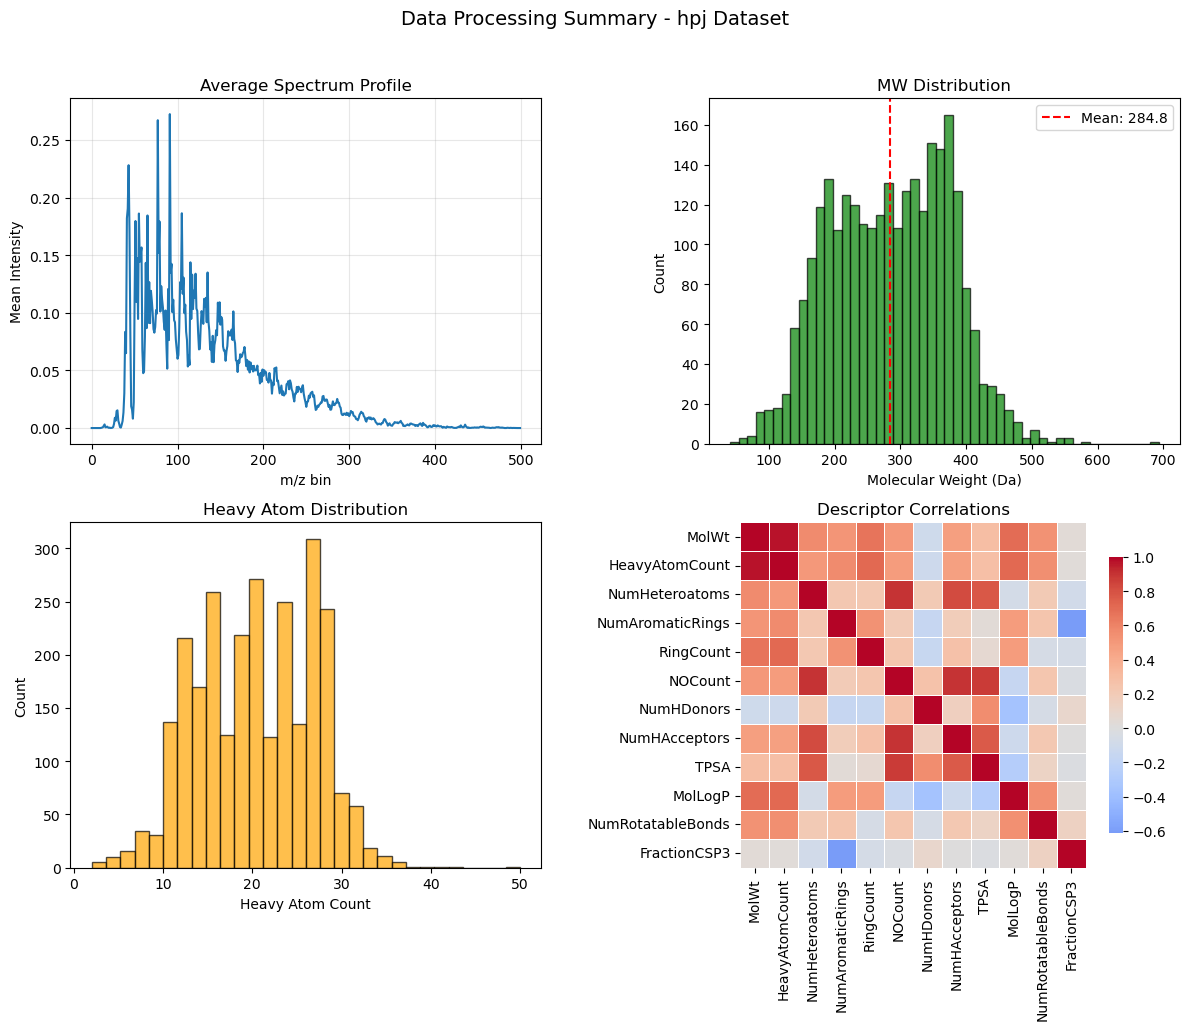


DATA PROCESSING SUMMARY

Dataset: hpj
Total samples processed: 2720

Spectrum properties:
  - Bins: 500
  - Transform: sqrt
  - Scaled: True
  - Mean non-zero bins: 128.1 ± 65.1

Molecular properties:
  - Mean MW: 284.8 ± 89.6 Da
  - MW range: [41.1, 692.9]
  - Mean heavy atoms: 20.3 ± 6.5


In [116]:
# Visualize data distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Spectrum coverage
all_spectra = np.vstack([processed_spectra[i] for i in range(min(1000, len(processed_spectra)))])
mean_spectrum = all_spectra.mean(axis=0)
axes[0, 0].plot(mean_spectrum)
axes[0, 0].set_xlabel('m/z bin')
axes[0, 0].set_ylabel('Mean Intensity')
axes[0, 0].set_title('Average Spectrum Profile')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Molecular weight distribution
mw_idx = MASTER_CONFIG['descriptors'].index('MolWt')
mw_values = descriptors[:, mw_idx]
axes[0, 1].hist(mw_values, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Molecular Weight (Da)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('MW Distribution')
axes[0, 1].axvline(mw_values.mean(), color='red', linestyle='--', label=f'Mean: {mw_values.mean():.1f}')
axes[0, 1].legend()

# Plot 3: Heavy atom count distribution
ha_idx = MASTER_CONFIG['descriptors'].index('HeavyAtomCount')
ha_values = descriptors[:, ha_idx]
axes[1, 0].hist(ha_values, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Heavy Atom Count')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Heavy Atom Distribution')

# Plot 4: Descriptor correlation heatmap
descriptor_df = pd.DataFrame(descriptors, columns=MASTER_CONFIG['descriptors'])
corr_matrix = descriptor_df.corr()
sns.heatmap(corr_matrix, ax=axes[1, 1], cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
axes[1, 1].set_title('Descriptor Correlations')

plt.suptitle(f'Data Processing Summary - {MASTER_CONFIG["dataset"]} Dataset', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("DATA PROCESSING SUMMARY")
print("="*60)
print(f"\nDataset: {MASTER_CONFIG['dataset']}")
print(f"Total samples processed: {len(complete_data)}")
print(f"\nSpectrum properties:")
print(f"  - Bins: {MASTER_CONFIG['spectrum']['n_bins']}")
print(f"  - Transform: {MASTER_CONFIG['spectrum']['transform']}")
print(f"  - Scaled: {MASTER_CONFIG['spectrum']['scale']}")
nonzero_bins = (processed_spectra > 0).sum(axis=1)
print(f"  - Mean non-zero bins: {nonzero_bins.mean():.1f} ± {nonzero_bins.std():.1f}")
print(f"\nMolecular properties:")
print(f"  - Mean MW: {mw_values.mean():.1f} ± {mw_values.std():.1f} Da")
print(f"  - MW range: [{mw_values.min():.1f}, {mw_values.max():.1f}]")
print(f"  - Mean heavy atoms: {ha_values.mean():.1f} ± {ha_values.std():.1f}")

## 9. Pipeline Completion Summary

### Data Transformation Pipeline Summary

```mermaid
flowchart LR
    In["Raw JSONL"] --> P1["Parse & Validate"]
    P1 --> P2["Bin Spectra (500 bins)"]
    P2 --> P3["√ Transform"]
    P3 --> P4["Normalize [0,1]"]
    P4 --> P5["Calculate Descriptors"]
    P5 --> P6["Standardize Features"]
    P6 --> P7["Split 80:10:10"]
    P7 --> Out["JSONL + Metadata"]
```

### Output Specifications

#### Data Dimensions
- **Spectral Features**: $\mathbf{X} \in [0,1]^{N \times 500}$
- **Molecular Descriptors**: $\mathbf{D} \in \mathbb{R}^{N \times 12}$
- **Standardized Descriptors**: $\tilde{\mathbf{D}} \in \mathbb{R}^{N \times 12}$, zero mean, unit variance


### Integration Points
Ready for downstream consumption by:
- **Part A**: Spectrum → Descriptors (LightGBM)
- **Part B**: Descriptors → SMILES (Conditional VAE)
- **End-to-End**: Direct spectrum → SMILES pipeline

In [117]:
print("\n" + "="*60)
print("DATA PREPARATION COMPLETE")
print("="*60)
print(f"\nProcessed dataset saved to: {output_dir}")
print("\nFiles created:")
print("  train_data.jsonl - Training data")
print("  val_data.jsonl - Validation data")
print("  test_data.jsonl - Test data")
print("  descriptor_scaler.pkl - Fitted StandardScaler")
print("  config.json - Processing configuration")
print("  metadata.json - Dataset metadata")

print("\nData structure per sample:")
print("  - smiles: SMILES string")
print("  - spectrum: binned spectrum (500 bins, sqrt-transformed, 0-1 scaled)")
print("  - target: same as spectrum (for compatibility)")
print("  - descriptors: raw descriptor values (12 features)")
print("  - descriptors_scaled: standardized descriptors")
print("  - descriptors_dict: descriptor name-value pairs")
print("  - original_peaks: original peak list")

print("\nReady for downstream notebooks:")
print("  - 01_spectra_to_descriptors.ipynb")
print("  - 02_descriptors_to_smiles.ipynb")
print("  - 03_spectra_to_smiles.ipynb")



DATA PREPARATION COMPLETE

Processed dataset saved to: ../data/processed/hpj

Files created:
  train_data.jsonl - Training data
  val_data.jsonl - Validation data
  test_data.jsonl - Test data
  descriptor_scaler.pkl - Fitted StandardScaler
  config.json - Processing configuration
  metadata.json - Dataset metadata

Data structure per sample:
  - smiles: SMILES string
  - spectrum: binned spectrum (500 bins, sqrt-transformed, 0-1 scaled)
  - target: same as spectrum (for compatibility)
  - descriptors: raw descriptor values (12 features)
  - descriptors_scaled: standardized descriptors
  - descriptors_dict: descriptor name-value pairs
  - original_peaks: original peak list

Ready for downstream notebooks:
  - 01_spectra_to_descriptors.ipynb
  - 02_descriptors_to_smiles.ipynb
  - 03_spectra_to_smiles.ipynb
